In [ ]:
## Regression Problem
        By Eng-Janvier NIYITEGEKA
        email: nijas2012@yahoo.com
           Data scientist
           MSc.IoT-ECS /UR-ACEIoT
        Assistant Lecturer/IPRC TUMBA

When solving a regression problem, the expected output is a continuous value. In a classification problem, the output is categorical.

Using the [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset, let's build a model to predict fuel efficiency.

In [ ]:
# Preliminary imports
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

Download the dataset

In [42]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

Next we would like to use Pandas to view the dataset on this notebook.

In [43]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

Q1. Write the Pandas function to return the number of "NaN" values per column. For simplicity, proceed to remove rows with "NaN" values:

In [44]:
# Write your answer here
d={1:'MPG',2:'Cylinders',3:'Displacement',4:'Horsepower',5:'Weight',6:'Acceleration',7:'Model Year',8:'Origin'}
for i in range(1,9):
    print("Numbers of  NaN in {} Column = {}".format(d[i],len(dataset[dataset[d[i]].isnull()])))

Numbers of  NaN in MPG Column = 0
Numbers of  NaN in Cylinders Column = 0
Numbers of  NaN in Displacement Column = 0
Numbers of  NaN in Horsepower Column = 6
Numbers of  NaN in Weight Column = 0
Numbers of  NaN in Acceleration Column = 0
Numbers of  NaN in Model Year Column = 0
Numbers of  NaN in Origin Column = 0


In [45]:
# Dropping NaN values
dataset=dataset.dropna()

The `"Origin"` column is categorical. Which means 1 stands for USA, 2 for Europe, and 3 for Japan. We wish to remove the `"Origin"` column and replace it with 3 new columns: USA, Europe, and Japan; each containing 1 for the corresponding row, otherwise zero.

In [46]:
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Now split the dataset into a training and test sets

In [47]:
train_ds = dataset.sample(frac=.8, random_state=0)
test_ds = dataset.drop(train_ds.index)

### Inspect/visualize the data

Q2. How can we have a quick look at the graphical distribution of the data? Use the `"MPG"`, "`Cylinders"`, "`Displacements"`, and "`Weight"` columns

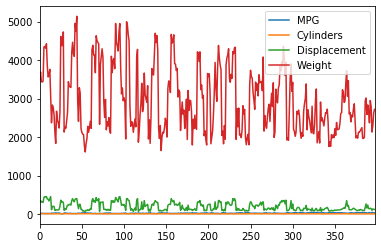

In [48]:
dataset=dataset.loc[:,['MPG','Cylinders','Displacement','Weight']]
dataset.plot()

To retrieve key statistical information using Pandas, we use the `describe()` function.
>Note: We apply a transpose to have the stastical information as columns

In [49]:
train_stats = train_ds.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Split features from labels

The `"MPG"` column contains our labels.

Q3. How can we separate that column from the rest of the columns?

In [50]:
y_train=train_ds.MPG
y_test=test_ds.MPG
train_ds=train_ds.drop(columns=['MPG'])
test_ds=test_ds.drop(columns=['MPG'])

In [51]:
def normalize(x):
    
    # Write your answer here
    # Compute the minimum value per feature on the training set
    min_on_training = train_ds.min(axis=0)
    # Compute the range of each feature (max - min) on the training set
    range_on_training = (train_ds - min_on_training).max(axis=0)

    # subtract the min, divide by range
    # afterward, min=0 and max=1 for each feature
    norm_data = (x - min_on_training) / range_on_training
    return norm_data

norm_train_data = normalize(train_ds)
norm_test_data = normalize(test_ds)

### The model

To build the model, you are encouraged to use the `Sequential` API from Keras to build a model with 2 densely connected layers, and output a single, continous value.
>Note: You may use an `SGD` or `RMSProp` optimizer with defaults learning rates

Hint: Here is the expected model architecture:

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
=================================================================
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
```

Q5. Define the function that builds the model:

In [52]:
def build_model():
    
    # Write your answer here
    from tensorflow.keras.activations import softmax, relu,sigmoid
    from tensorflow.keras.models import Sequential, Model
    from keras.optimizers import SGD,adam,RMSprop
    from tensorflow.keras.layers import Dense
    
    model=Sequential()
    model.add(Dense(64,activation='relu',input_dim=9))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### Train the model

Q6.Train the model for 1,000 epochs and note the training and validation accuracy in an `history` object. Use 20% of the training data for validation/testing

In [53]:
model.compile(optimizer='SGD', loss='mse', metrics=['acc'])

In [54]:
EPOCHS = 1000

history = model.fit(norm_train_data,y_train, validation_data=(norm_test_data, y_test), epochs=EPOCHS)

Train on 314 samples, validate on 78 samples
Epoch 1/1000
314/314 [==============================] - 1s 2ms/sample - loss: 565.7701 - acc: 0.0000e+00 - val_loss: 595.0187 - val_acc: 0.0000e+00
Epoch 2/1000
314/314 [==============================] - 0s 283us/sample - loss: 557.9613 - acc: 0.0000e+00 - val_loss: 594.2182 - val_acc: 0.0000e+00
Epoch 3/1000
314/314 [==============================] - 0s 188us/sample - loss: 557.5553 - acc: 0.0000e+00 - val_loss: 594.0628 - val_acc: 0.0000e+00
Epoch 4/1000
314/314 [==============================] - 0s 357us/sample - loss: 557.4482 - acc: 0.0000e+00 - val_loss: 594.0029 - val_acc: 0.0000e+00
Epoch 5/1000
314/314 [==============================] - 0s 261us/sample - loss: 557.4014 - acc: 0.0000e+00 - val_loss: 593.9724 - val_acc: 0.0000e+00
Epoch 6/1000
314/314 [==============================] - 0s 194us/sample - loss: 557.3758 - acc: 0.0000e+00 - val_loss: 593.9543 - val_acc: 0.0000e+00
Epoch 7/1000
314/314 [==============================] - 0

314/314 [==============================] - 0s 162us/sample - loss: 557.3045 - acc: 0.0000e+00 - val_loss: 593.8974 - val_acc: 0.0000e+00
Epoch 56/1000
314/314 [==============================] - 0s 172us/sample - loss: 557.3044 - acc: 0.0000e+00 - val_loss: 593.8973 - val_acc: 0.0000e+00
Epoch 57/1000
314/314 [==============================] - 0s 169us/sample - loss: 557.3044 - acc: 0.0000e+00 - val_loss: 593.8972 - val_acc: 0.0000e+00
Epoch 58/1000
314/314 [==============================] - 0s 153us/sample - loss: 557.3043 - acc: 0.0000e+00 - val_loss: 593.8971 - val_acc: 0.0000e+00
Epoch 59/1000
314/314 [==============================] - 0s 166us/sample - loss: 557.3042 - acc: 0.0000e+00 - val_loss: 593.8971 - val_acc: 0.0000e+00
Epoch 60/1000
314/314 [==============================] - 0s 188us/sample - loss: 557.3041 - acc: 0.0000e+00 - val_loss: 593.8970 - val_acc: 0.0000e+00
Epoch 61/1000
314/314 [==============================] - 0s 207us/sample - loss: 557.3041 - acc: 0.0000e+00 

Epoch 163/1000
314/314 [==============================] - 0s 166us/sample - loss: 557.3017 - acc: 0.0000e+00 - val_loss: 593.8949 - val_acc: 0.0000e+00
Epoch 164/1000
314/314 [==============================] - 0s 191us/sample - loss: 557.3017 - acc: 0.0000e+00 - val_loss: 593.8949 - val_acc: 0.0000e+00
Epoch 165/1000
314/314 [==============================] - 0s 156us/sample - loss: 557.3017 - acc: 0.0000e+00 - val_loss: 593.8949 - val_acc: 0.0000e+00
Epoch 166/1000
314/314 [==============================] - 0s 188us/sample - loss: 557.3017 - acc: 0.0000e+00 - val_loss: 593.8948 - val_acc: 0.0000e+00
Epoch 167/1000
314/314 [==============================] - 0s 172us/sample - loss: 557.3017 - acc: 0.0000e+00 - val_loss: 593.8949 - val_acc: 0.0000e+00
Epoch 168/1000
314/314 [==============================] - 0s 175us/sample - loss: 557.3017 - acc: 0.0000e+00 - val_loss: 593.8948 - val_acc: 0.0000e+00
Epoch 169/1000
314/314 [==============================] - 0s 166us/sample - loss: 557.30

Epoch 217/1000
314/314 [==============================] - 0s 172us/sample - loss: 557.3014 - acc: 0.0000e+00 - val_loss: 593.8946 - val_acc: 0.0000e+00
Epoch 218/1000
314/314 [==============================] - 0s 175us/sample - loss: 557.3014 - acc: 0.0000e+00 - val_loss: 593.8946 - val_acc: 0.0000e+00
Epoch 219/1000
314/314 [==============================] - 0s 156us/sample - loss: 557.3014 - acc: 0.0000e+00 - val_loss: 593.8946 - val_acc: 0.0000e+00
Epoch 220/1000
314/314 [==============================] - 0s 185us/sample - loss: 557.3014 - acc: 0.0000e+00 - val_loss: 593.8946 - val_acc: 0.0000e+00
Epoch 221/1000
314/314 [==============================] - 0s 201us/sample - loss: 557.3014 - acc: 0.0000e+00 - val_loss: 593.8946 - val_acc: 0.0000e+00
Epoch 222/1000
314/314 [==============================] - 0s 172us/sample - loss: 557.3014 - acc: 0.0000e+00 - val_loss: 593.8946 - val_acc: 0.0000e+00
Epoch 223/1000
314/314 [==============================] - 0s 162us/sample - loss: 557.30

Epoch 271/1000
314/314 [==============================] - 0s 175us/sample - loss: 557.3012 - acc: 0.0000e+00 - val_loss: 593.8945 - val_acc: 0.0000e+00
Epoch 272/1000
314/314 [==============================] - 0s 175us/sample - loss: 557.3012 - acc: 0.0000e+00 - val_loss: 593.8944 - val_acc: 0.0000e+00
Epoch 273/1000
314/314 [==============================] - 0s 175us/sample - loss: 557.3012 - acc: 0.0000e+00 - val_loss: 593.8944 - val_acc: 0.0000e+00
Epoch 274/1000
314/314 [==============================] - 0s 172us/sample - loss: 557.3012 - acc: 0.0000e+00 - val_loss: 593.8945 - val_acc: 0.0000e+00
Epoch 275/1000
314/314 [==============================] - 0s 169us/sample - loss: 557.3012 - acc: 0.0000e+00 - val_loss: 593.8945 - val_acc: 0.0000e+00
Epoch 276/1000
314/314 [==============================] - 0s 166us/sample - loss: 557.3012 - acc: 0.0000e+00 - val_loss: 593.8945 - val_acc: 0.0000e+00
Epoch 277/1000
314/314 [==============================] - 0s 185us/sample - loss: 557.30

Epoch 325/1000
314/314 [==============================] - 0s 194us/sample - loss: 557.3011 - acc: 0.0000e+00 - val_loss: 593.8944 - val_acc: 0.0000e+00
Epoch 326/1000
314/314 [==============================] - 0s 134us/sample - loss: 557.3011 - acc: 0.0000e+00 - val_loss: 593.8944 - val_acc: 0.0000e+00
Epoch 327/1000
314/314 [==============================] - 0s 150us/sample - loss: 557.3011 - acc: 0.0000e+00 - val_loss: 593.8944 - val_acc: 0.0000e+00
Epoch 328/1000
314/314 [==============================] - 0s 127us/sample - loss: 557.3011 - acc: 0.0000e+00 - val_loss: 593.8943 - val_acc: 0.0000e+00
Epoch 329/1000
314/314 [==============================] - 0s 131us/sample - loss: 557.3011 - acc: 0.0000e+00 - val_loss: 593.8943 - val_acc: 0.0000e+00
Epoch 330/1000
314/314 [==============================] - 0s 162us/sample - loss: 557.3011 - acc: 0.0000e+00 - val_loss: 593.8944 - val_acc: 0.0000e+00
Epoch 331/1000
314/314 [==============================] - 0s 153us/sample - loss: 557.30

Epoch 379/1000
314/314 [==============================] - 0s 134us/sample - loss: 557.3010 - acc: 0.0000e+00 - val_loss: 593.8943 - val_acc: 0.0000e+00
Epoch 380/1000
314/314 [==============================] - 0s 150us/sample - loss: 557.3011 - acc: 0.0000e+00 - val_loss: 593.8943 - val_acc: 0.0000e+00
Epoch 381/1000
314/314 [==============================] - 0s 131us/sample - loss: 557.3010 - acc: 0.0000e+00 - val_loss: 593.8943 - val_acc: 0.0000e+00
Epoch 382/1000
314/314 [==============================] - 0s 140us/sample - loss: 557.3010 - acc: 0.0000e+00 - val_loss: 593.8943 - val_acc: 0.0000e+00
Epoch 383/1000
314/314 [==============================] - 0s 134us/sample - loss: 557.3010 - acc: 0.0000e+00 - val_loss: 593.8943 - val_acc: 0.0000e+00
Epoch 384/1000
314/314 [==============================] - 0s 150us/sample - loss: 557.3010 - acc: 0.0000e+00 - val_loss: 593.8943 - val_acc: 0.0000e+00
Epoch 385/1000
314/314 [==============================] - 0s 134us/sample - loss: 557.30

Epoch 486/1000
314/314 [==============================] - 0s 127us/sample - loss: 557.3010 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 487/1000
314/314 [==============================] - 0s 127us/sample - loss: 557.3010 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 488/1000
314/314 [==============================] - 0s 105us/sample - loss: 557.3010 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 489/1000
314/314 [==============================] - 0s 127us/sample - loss: 557.3010 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 490/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3010 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 491/1000
314/314 [==============================] - 0s 121us/sample - loss: 557.3010 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 492/1000
314/314 [==============================] - 0s 115us/sample - loss: 557.30

Epoch 540/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 541/1000
314/314 [==============================] - 0s 121us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 542/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 543/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 544/1000
314/314 [==============================] - 0s 118us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 545/1000
314/314 [==============================] - 0s 115us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 546/1000
314/314 [==============================] - 0s 121us/sample - loss: 557.30

Epoch 594/1000
314/314 [==============================] - 0s 131us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 595/1000
314/314 [==============================] - 0s 137us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 596/1000
314/314 [==============================] - 0s 105us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 597/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 598/1000
314/314 [==============================] - 0s 105us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 599/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 600/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.30

Epoch 648/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 649/1000
314/314 [==============================] - 0s 96us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 650/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 651/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 652/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 653/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 654/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.300

Epoch 702/1000
314/314 [==============================] - 0s 96us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 703/1000
314/314 [==============================] - 0s 124us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 704/1000
314/314 [==============================] - 0s 96us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 705/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 706/1000
314/314 [==============================] - 0s 99us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 707/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3009 - acc: 0.0000e+00 - val_loss: 593.8942 - val_acc: 0.0000e+00
Epoch 708/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3009 

Epoch 756/1000
314/314 [==============================] - 0s 118us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 757/1000
314/314 [==============================] - 0s 99us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 758/1000
314/314 [==============================] - 0s 124us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 759/1000
314/314 [==============================] - 0s 118us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 760/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 761/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 762/1000
314/314 [==============================] - 0s 102us/sample - loss: 557.300

Epoch 810/1000
314/314 [==============================] - 0s 105us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 811/1000
314/314 [==============================] - 0s 115us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 812/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 813/1000
314/314 [==============================] - 0s 96us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 814/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 815/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 816/1000
314/314 [==============================] - 0s 105us/sample - loss: 557.300

Epoch 864/1000
314/314 [==============================] - 0s 105us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 865/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 866/1000
314/314 [==============================] - 0s 102us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 867/1000
314/314 [==============================] - 0s 105us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 868/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 869/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 870/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.30

Epoch 918/1000
314/314 [==============================] - 0s 115us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 919/1000
314/314 [==============================] - 0s 115us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 920/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 921/1000
314/314 [==============================] - 0s 99us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 922/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 923/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 924/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.300

Epoch 972/1000
314/314 [==============================] - 0s 115us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8940 - val_acc: 0.0000e+00
Epoch 973/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 974/1000
314/314 [==============================] - 0s 99us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8940 - val_acc: 0.0000e+00
Epoch 975/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 976/1000
314/314 [==============================] - 0s 111us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 977/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.3008 - acc: 0.0000e+00 - val_loss: 593.8941 - val_acc: 0.0000e+00
Epoch 978/1000
314/314 [==============================] - 0s 108us/sample - loss: 557.300

#### Show the History as a Pandas DataFrame

In [37]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,acc,val_loss,val_acc,epoch
995,556.541682,0.0,583.252334,0.0,995
996,556.541673,0.0,583.252328,0.0,996
997,556.541679,0.0,583.252366,0.0,997
998,556.541675,0.0,583.252353,0.0,998
999,556.541664,0.0,583.252315,0.0,999


### Plotting the training curve

Q7. Show via a graph how the error was minimized during training and validation/testing. Make 2 graphs, one for MAE and another for MSE.
- **val_mae** stands for Validation Mean Absolute Error
- **mae** stands for Mean Absolute Error
- **val_mse** stands for Validation Mean Square Error
- **mse** stands for Mean Square Error

In [38]:
norm_train_data=norm_train_data.to_numpy()
y_train=y_train.to_numpy()

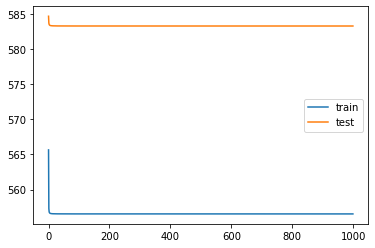

In [39]:
# Solution
def plot_history(history):
  # Write your answer here
   plt.plot(history.history['loss'], label='train')
   plt.plot(history.history['val_loss'], label='test')
   plt.legend()
   plt.show()
  
plot_history(history)

Q8.Looking at the 2 graphs above, what parameters should we change to improve the model and/or the training?
1. Reduce epochs
2. Increase epochs
3. Use a value of 0.3 for `validation_split`
4. None of the above

In [40]:
# Write the number of your solution here: 
1,3

(1, 3)

Q9. How can we use `EarlyStopping` from Keras to stop the training when `val_loss` is not improving? Write the missing code

Epoch 00097: early stopping


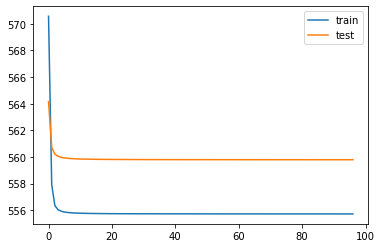

In [41]:
model = build_model()
from keras.callbacks import EarlyStopping
model.compile(optimizer='SGD', loss='mse', metrics=['acc'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(norm_train_data,y_train, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop])

plot_history(history)

END